In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ASTForAudioClassification, AutoProcessor
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import json
from datetime import datetime



In [3]:
Ravdess = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/"
Crema   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/"
Tess    = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/"
Savee   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/"

In [ ]:

ravdess_directory_list = [d for d in os.listdir(Ravdess) if d.startswith("Actor_")]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue  
        
        part = file.split('.')[0].split('-')
        
        if len(part) != 7:
            print(f"⚠️ Skipping malformed file: {file}")
            continue
        
        try:
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_folder, file))
        except ValueError:
            print(f"❌ Couldn't parse emotion code in: {file}")


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].map(emotion_labels)

print(Ravdess_df.head())
print(Ravdess_df["Path"].values[1])

  Emotions                                               Path
0  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4     calm  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/Actor_01/03-01-01-01-01-02-01.wav


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/1001_DFA_DIS_XX.wav


In [ ]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/"+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df['Path'].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/DC_a02.wav


In [8]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4,calm,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
...,...,...
475,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
476,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
477,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
478,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...


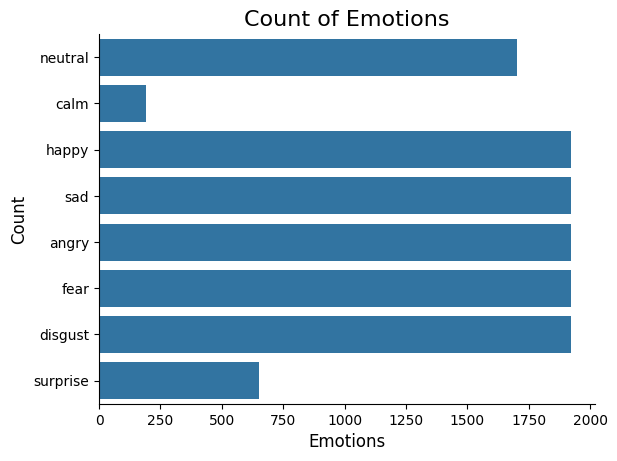

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:


os.makedirs("checkpoints", exist_ok=True)
os.makedirs("best_models", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("final_models", exist_ok=True)




def volume_perturbation(data, low=0.5, high=1.5):
    factor = np.random.uniform(low, high)
    return data * factor

def clipping_distortion(data, clip_percent=0.02):
    threshold = clip_percent * np.max(np.abs(data))
    data = np.clip(data, -threshold, threshold)
    return data

def pink_noise(data):

    uneven = data.shape[0] % 2
    X = np.random.randn(data.shape[0]//2 + 1 + uneven) + 1j * np.random.randn(data.shape[0]//2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)  
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    y = y / np.max(np.abs(y))
    return data + 0.005 * y

def salt_and_pepper_audio(data, amount=0.005):
    noisy_data = data.copy()
    num_samples = int(amount * data.shape[0])
    indices = np.random.randint(0, data.shape[0], num_samples)
    for i in indices:
        noisy_data[i] = np.random.choice([np.min(data), np.max(data)])
    return noisy_data

def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=steps)

def unfreeze_last_layers(model, num_layers=2):
    for name, param in model.named_parameters():
        if any(f"layer.{i}" in name for i in range(11, 11 - num_layers, -1)):
            param.requires_grad = True


# ========== Dataset ==========
class EmotionAudioDataset(Dataset):
    def __init__(self, dataframe, processor_name="MIT/ast-finetuned-speech-commands-v2", train=True):
        df = dataframe.copy().dropna().reset_index(drop=True)

        # Encode emotions to integers
        self.label_map = {emotion: i for i, emotion in enumerate(sorted(df["Emotions"].unique()))}
        self.df = df.copy()
        self.df["label"] = self.df["Emotions"].map(self.label_map)
        
        # Stratified split
        train_df, val_df = train_test_split(self.df, test_size=0.2, stratify=self.df["label"], random_state=42)

        
        self.df = train_df if train else val_df
             # Step 2: Augment training set
        augmented_rows_train = []
        for _, row in self.df.iterrows():
            for aug_type in ["original", "noise", "stretch_pitch", "salt_pepper", "pink", "clip", "volume"]:
                augmented_rows_train.append({
                    "Path": row["Path"],
                    "Emotions": row["Emotions"],
                    "label": row["label"],  # <-- ЭТО ВАЖНО
                    "AugType": aug_type
                })
        self.df = pd.DataFrame(augmented_rows_train)

        self.processor = AutoProcessor.from_pretrained(processor_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["Path"]
        label = row["label"]
        aug_type = row["AugType"]

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)
        
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        waveform = waveform.squeeze().numpy()
        
        # Resample if needed
        if sample_rate != 16000:
            waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)
            sample_rate = 16000

        # Apply augmentation
        if aug_type == "noise":
            waveform = add_noise(waveform)
        elif aug_type == "stretch_pitch":
            waveform = stretch(waveform)
            waveform = pitch(waveform, sample_rate)
        elif aug_type == "salt_pepper":
            waveform = salt_and_pepper_audio(waveform)
        elif aug_type == "pink":
            waveform = pink_noise(waveform)
        elif aug_type == "clip":
            waveform = clipping_distortion(waveform)
        elif aug_type == "volume":
            waveform = volume_perturbation(waveform)

        

        # Back to tensor
        waveform = torch.tensor(waveform)

        try:
            processed = self.processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                max_length=16000
            )
            input_values = processed.input_values.squeeze(0)
        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)

        return input_values, torch.tensor(label)

# ========== Classifier ==========
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)
    

class ComplexClassifierHead(nn.Module):
    def __init__(self, input_dim=768, num_classes=8):
        super().__init__()
        self.norm = nn.BatchNorm1d(input_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):  # x: [B, T, D]
        x = x.transpose(1, 2)       # [B, D, T]
        x = self.norm(x)            # BatchNorm1d expects [B, D, T]
        x = x.transpose(1, 2)       # back to [B, T, D]
    
        mean_pool = x.mean(dim=1)   # [B, D]
        max_pool, _ = x.max(dim=1)  # [B, D]
        fused = torch.cat([mean_pool, max_pool], dim=1)  # [B, 2D]
        return self.fc(fused)       # [B, num_classes]



def save_checkpoint(model, optimizer, epoch, path="checkpoints/checkpoint.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# ========== Training ==========
def train_model(model, train_loader, val_loader, label_map, num_epochs=10, learning_rate=2e-5, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)

    train_labels = train_loader.dataset.df["label"]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # log for saving full metrics
    metrics_log = []

    start_epoch = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)


    best_f1 = 0.0  # put this before the loop
    for epoch in range(start_epoch, num_epochs):

        print(f"\nEpoch {epoch+1}/{num_epochs}")


        ast_unfrozen = False
        # === Unfreeze AST backbone after epoch 15 ===
        if epoch == 15 and not ast_unfrozen:
            print("🔓 Unfreezing last AST layers...")
            unfreeze_last_layers(model.audio_spectrogram_transformer)
            optimizer = optim.AdamW([
                {"params": model.audio_spectrogram_transformer.parameters(), "lr": 1e-5},
                {"params": model.classifier.parameters(), "lr": 2e-4}
            ])
            ast_unfrozen = True

        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            ast_outputs = model.audio_spectrogram_transformer(input_values=inputs,output_hidden_states=True,return_dict=True)
            patch_tokens = ast_outputs.last_hidden_state[:, 1:, :]  # [B, T, D]
            logits = model.classifier(patch_tokens)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
        
                ast_outputs = model.audio_spectrogram_transformer(
                    input_values=inputs,
                    output_hidden_states=True,
                    return_dict=True
                )
                patch_tokens = ast_outputs.last_hidden_state[:, 1:, :]
                logits = model.classifier(patch_tokens)
        
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, predicted = logits.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        
                val_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Get full classification report
        target_names = list(label_map.keys())
        report = classification_report(
            all_labels, all_preds,
            target_names=target_names,
            digits=4,
            output_dict=True
        )

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"F1 Score: {f1_weighted:.4f}")
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

    
        best_model_path = "best_models/best_f1_model.pth"

        
        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            torch.save(model.state_dict(), best_model_path)
            print(f"💾 Best model saved with F1: {best_f1:.4f}")

        save_checkpoint(model, optimizer, epoch + 1, path=f"checkpoints/epoch_{epoch+1}.pth")

        # Flatten the classification report
        flat_report = {
            f"{label}_{metric}": round(value, 4)
            for label, scores in report.items()
            for metric, value in (scores.items() if isinstance(scores, dict) else [("value", scores)])
        }

        # Save all metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "timestamp": datetime.now().isoformat(),
            "train_loss": round(train_loss, 4),
            "train_accuracy": round(train_acc, 2),
            "val_loss": round(val_loss, 4),
            "val_accuracy": round(val_acc, 2),
            "f1_weighted": round(f1_weighted, 4),
            "f1_macro": round(f1_macro, 4),
            "report": flat_report
        }

        metrics_log.append(epoch_metrics)
        # 🔽 Save updated metrics to file
        with open("logs/metrics_log.json", "w") as f:
            json.dump(metrics_log, f, indent=2)

    torch.save(model.state_dict(), "final_models/With_Development_Of_New_HEads_final_model_state_dict.pth")
    torch.save(model, "final_models/With_Development_Of_New_HEads_final_model_full.pth")
    print("📦 Final model saved to 'final_models/' folder.")

    # Plot and save curves
    total_epochs_ran = range(start_epoch + 1, start_epoch + len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs_ran, train_losses, label='Train Loss')
    plt.plot(total_epochs_ran, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(total_epochs_ran, train_accs, label='Train Acc')
    plt.plot(total_epochs_ran, val_accs, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.savefig(f"plots/training_curves_epoch_{num_epochs}.png")

    plt.show()


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"\u2705 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

# ========== Main ==========
if __name__ == "__main__":



    train_dataset = EmotionAudioDataset(data_path, train=True)
    val_dataset = EmotionAudioDataset(data_path, train=False)


    

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-speech-commands-v2",
        num_labels=len(train_dataset.label_map),
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = False

    # custom_clf = CustomClassifier(model.config.hidden_size, len(train_dataset.label_map))
    # model.classifier = custom_clf

    custom_clf = ComplexClassifierHead(model.config.hidden_size, len(train_dataset.label_map))
    model.classifier = custom_clf

    for param in model.classifier.parameters():
        param.requires_grad = True

    train_model(
    model,
    train_loader,
    val_loader,
    label_map=train_dataset.label_map,
    num_epochs=75
    )

    torch.save(model.state_dict(), "New_Head_Developed_final_state_model.pth")
    torch.save(model, "New_Head_Developed_final_model.pth")

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/75

Epoch 1/75


Epoch 1, Loss: 1.6094, Accuracy: 32.38%


Validation Loss: 1.4665, Accuracy: 43.43%
F1 Score: 0.4203
              precision    recall  f1-score   support

       angry     0.4900    0.6620    0.5631      2695
        calm     0.1998    0.9398    0.3296       266
     disgust     0.3837    0.4059    0.3945      2695
        fear     0.4354    0.3054    0.3590      2695
       happy     0.4641    0.1918    0.2715      2695
     neutral     0.4207    0.5748    0.4858      2380
         sad     0.5859    0.3239    0.4172      2695
    surprise     0.4462    0.7560    0.5612       910

    accuracy                         0.4343     17031
   macro avg     0.4282    0.5200    0.4227     17031
weighted avg     0.4591    0.4343    0.4203     17031

💾 Best model saved with F1: 0.4203
✅ Checkpoint saved at epoch 1

Epoch 2/75

Epoch 2/75


Epoch 2, Loss: 1.3683, Accuracy: 42.93%


Validation Loss: 1.3476, Accuracy: 47.67%
F1 Score: 0.4627
              precision    recall  f1-score   support

       angry     0.5945    0.6594    0.6253      2695
        calm     0.2058    0.9812    0.3403       266
     disgust     0.5739    0.2534    0.3516      2695
        fear     0.4708    0.3503    0.4017      2695
       happy     0.4952    0.2497    0.3320      2695
     neutral     0.4371    0.6513    0.5231      2380
         sad     0.4928    0.5610    0.5247      2695
    surprise     0.4477    0.7901    0.5715       910

    accuracy                         0.4767     17031
   macro avg     0.4647    0.5621    0.4588     17031
weighted avg     0.5040    0.4767    0.4627     17031

💾 Best model saved with F1: 0.4627
✅ Checkpoint saved at epoch 2

Epoch 3/75

Epoch 3/75


Epoch 3, Loss: 1.2666, Accuracy: 47.22%


Validation Loss: 1.2734, Accuracy: 49.80%
F1 Score: 0.4934
              precision    recall  f1-score   support

       angry     0.6880    0.5744    0.6261      2695
        calm     0.2328    0.9511    0.3740       266
     disgust     0.5197    0.3273    0.4016      2695
        fear     0.4892    0.3603    0.4150      2695
       happy     0.4787    0.3714    0.4183      2695
     neutral     0.4479    0.6412    0.5274      2380
         sad     0.4962    0.5863    0.5375      2695
    surprise     0.5414    0.7912    0.6429       910

    accuracy                         0.4980     17031
   macro avg     0.4867    0.5754    0.4928     17031
weighted avg     0.5180    0.4980    0.4934     17031

💾 Best model saved with F1: 0.4934
✅ Checkpoint saved at epoch 3

Epoch 4/75

Epoch 4/75


Epoch 4, Loss: 1.2007, Accuracy: 49.67%


Validation Loss: 1.2239, Accuracy: 51.49%
F1 Score: 0.5079
              precision    recall  f1-score   support

       angry     0.6600    0.6720    0.6659      2695
        calm     0.2329    0.9699    0.3755       266
     disgust     0.5063    0.3881    0.4394      2695
        fear     0.5282    0.3855    0.4457      2695
       happy     0.5854    0.2950    0.3923      2695
     neutral     0.4466    0.6765    0.5380      2380
         sad     0.5490    0.5447    0.5468      2695
    surprise     0.4924    0.8165    0.6143       910

    accuracy                         0.5149     17031
   macro avg     0.5001    0.5935    0.5023     17031
weighted avg     0.5400    0.5149    0.5079     17031

💾 Best model saved with F1: 0.5079
✅ Checkpoint saved at epoch 4

Epoch 5/75

Epoch 5/75


Epoch 5, Loss: 1.1536, Accuracy: 51.42%


Validation Loss: 1.1811, Accuracy: 53.03%
F1 Score: 0.5254
              precision    recall  f1-score   support

       angry     0.6412    0.7050    0.6716      2695
        calm     0.2441    0.9662    0.3897       266
     disgust     0.5172    0.4193    0.4631      2695
        fear     0.5461    0.3536    0.4293      2695
       happy     0.5195    0.4111    0.4590      2695
     neutral     0.4978    0.6235    0.5536      2380
         sad     0.5556    0.5417    0.5486      2695
    surprise     0.5503    0.8121    0.6560       910

    accuracy                         0.5303     17031
   macro avg     0.5090    0.6041    0.5214     17031
weighted avg     0.5426    0.5303    0.5254     17031

💾 Best model saved with F1: 0.5254
✅ Checkpoint saved at epoch 5

Epoch 6/75

Epoch 6/75


Epoch 6, Loss: 1.1188, Accuracy: 52.85%


Validation Loss: 1.1699, Accuracy: 53.07%
F1 Score: 0.5209
              precision    recall  f1-score   support

       angry     0.6416    0.7161    0.6768      2695
        calm     0.2335    0.9812    0.3772       266
     disgust     0.5728    0.3473    0.4324      2695
        fear     0.5747    0.3540    0.4381      2695
       happy     0.5812    0.3414    0.4301      2695
     neutral     0.5232    0.6256    0.5698      2380
         sad     0.4836    0.6664    0.5605      2695
    surprise     0.5123    0.8264    0.6325       910

    accuracy                         0.5307     17031
   macro avg     0.5154    0.6073    0.5147     17031
weighted avg     0.5557    0.5307    0.5209     17031

✅ Checkpoint saved at epoch 6

Epoch 7/75

Epoch 7/75


Epoch 7, Loss: 1.0843, Accuracy: 54.43%


Validation Loss: 1.1406, Accuracy: 54.33%
F1 Score: 0.5421
              precision    recall  f1-score   support

       angry     0.6719    0.7050    0.6880      2695
        calm     0.2334    0.9887    0.3776       266
     disgust     0.5100    0.4353    0.4697      2695
        fear     0.5709    0.3733    0.4514      2695
       happy     0.4983    0.4868    0.4925      2695
     neutral     0.5850    0.5391    0.5611      2380
         sad     0.5462    0.5881    0.5664      2695
    surprise     0.5684    0.8033    0.6658       910

    accuracy                         0.5433     17031
   macro avg     0.5230    0.6149    0.5341     17031
weighted avg     0.5584    0.5433    0.5421     17031

💾 Best model saved with F1: 0.5421
✅ Checkpoint saved at epoch 7

Epoch 8/75

Epoch 8/75


Epoch 8, Loss: 1.0623, Accuracy: 55.14%


Validation Loss: 1.1170, Accuracy: 54.86%
F1 Score: 0.5466
              precision    recall  f1-score   support

       angry     0.6646    0.7221    0.6922      2695
        calm     0.2775    0.9774    0.4323       266
     disgust     0.5084    0.4698    0.4883      2695
        fear     0.4800    0.4668    0.4733      2695
       happy     0.5703    0.4063    0.4745      2695
     neutral     0.6154    0.5445    0.5778      2380
         sad     0.5857    0.5388    0.5613      2695
    surprise     0.4974    0.8473    0.6268       910

    accuracy                         0.5486     17031
   macro avg     0.5249    0.6216    0.5408     17031
weighted avg     0.5614    0.5486    0.5466     17031

💾 Best model saved with F1: 0.5466
✅ Checkpoint saved at epoch 8

Epoch 9/75

Epoch 9/75


Epoch 9, Loss: 1.0375, Accuracy: 55.95%


Validation Loss: 1.1160, Accuracy: 54.40%
F1 Score: 0.5382
              precision    recall  f1-score   support

       angry     0.6445    0.7380    0.6881      2695
        calm     0.2899    0.9699    0.4464       266
     disgust     0.4503    0.5199    0.4826      2695
        fear     0.5792    0.3881    0.4648      2695
       happy     0.6048    0.3521    0.4451      2695
     neutral     0.5894    0.5622    0.5755      2380
         sad     0.5691    0.5547    0.5618      2695
    surprise     0.4719    0.8670    0.6112       910

    accuracy                         0.5440     17031
   macro avg     0.5249    0.6190    0.5344     17031
weighted avg     0.5628    0.5440    0.5382     17031

✅ Checkpoint saved at epoch 9

Epoch 10/75

Epoch 10/75


Epoch 10, Loss: 1.0173, Accuracy: 56.79%


Validation Loss: 1.0928, Accuracy: 55.97%
F1 Score: 0.5528
              precision    recall  f1-score   support

       angry     0.6519    0.7443    0.6951      2695
        calm     0.2826    0.9699    0.4377       266
     disgust     0.5535    0.4512    0.4971      2695
        fear     0.6285    0.3629    0.4601      2695
       happy     0.5982    0.4171    0.4915      2695
     neutral     0.4839    0.7130    0.5765      2380
         sad     0.5655    0.5577    0.5616      2695
    surprise     0.6037    0.8253    0.6973       910

    accuracy                         0.5597     17031
   macro avg     0.5460    0.6302    0.5521     17031
weighted avg     0.5786    0.5597    0.5528     17031

💾 Best model saved with F1: 0.5528
✅ Checkpoint saved at epoch 10

Epoch 11/75

Epoch 11/75


Epoch 11, Loss: 1.0042, Accuracy: 57.52%


Validation Loss: 1.1054, Accuracy: 55.13%
F1 Score: 0.5454
              precision    recall  f1-score   support

       angry     0.7123    0.6853    0.6986      2695
        calm     0.2593    0.9925    0.4112       266
     disgust     0.4713    0.5265    0.4974      2695
        fear     0.6664    0.3662    0.4727      2695
       happy     0.6656    0.3228    0.4348      2695
     neutral     0.5057    0.6735    0.5777      2380
         sad     0.5404    0.6074    0.5720      2695
    surprise     0.5359    0.8374    0.6535       910

    accuracy                         0.5513     17031
   macro avg     0.5446    0.6265    0.5397     17031
weighted avg     0.5869    0.5513    0.5454     17031

✅ Checkpoint saved at epoch 11

Epoch 12/75

Epoch 12/75


Epoch 12, Loss: 0.9860, Accuracy: 58.28%


Validation Loss: 1.0732, Accuracy: 57.08%
F1 Score: 0.5654
              precision    recall  f1-score   support

       angry     0.6585    0.7514    0.7019      2695
        calm     0.2646    0.9850    0.4172       266
     disgust     0.5603    0.4516    0.5001      2695
        fear     0.6031    0.4037    0.4837      2695
       happy     0.6434    0.4045    0.4967      2695
     neutral     0.5540    0.6508    0.5985      2380
         sad     0.5291    0.6453    0.5814      2695
    surprise     0.6200    0.8264    0.7084       910

    accuracy                         0.5708     17031
   macro avg     0.5541    0.6398    0.5610     17031
weighted avg     0.5885    0.5708    0.5654     17031

💾 Best model saved with F1: 0.5654
✅ Checkpoint saved at epoch 12

Epoch 13/75

Epoch 13/75


Epoch 13, Loss: 0.9738, Accuracy: 58.43%


Validation Loss: 1.0619, Accuracy: 57.17%
F1 Score: 0.5673
              precision    recall  f1-score   support

       angry     0.6551    0.7662    0.7063      2695
        calm     0.3184    0.9361    0.4752       266
     disgust     0.5843    0.4460    0.5059      2695
        fear     0.5051    0.5102    0.5077      2695
       happy     0.5826    0.4527    0.5095      2695
     neutral     0.5632    0.6218    0.5911      2380
         sad     0.6384    0.5050    0.5639      2695
    surprise     0.5355    0.8615    0.6605       910

    accuracy                         0.5717     17031
   macro avg     0.5478    0.6375    0.5650     17031
weighted avg     0.5816    0.5717    0.5673     17031

💾 Best model saved with F1: 0.5673
✅ Checkpoint saved at epoch 13

Epoch 14/75

Epoch 14/75


Epoch 14, Loss: 0.9585, Accuracy: 59.31%


Validation Loss: 1.0587, Accuracy: 57.32%
F1 Score: 0.5654
              precision    recall  f1-score   support

       angry     0.6502    0.7703    0.7052      2695
        calm     0.2887    0.9812    0.4462       266
     disgust     0.6441    0.3963    0.4907      2695
        fear     0.6247    0.3811    0.4734      2695
       happy     0.5808    0.4827    0.5273      2695
     neutral     0.5186    0.7105    0.5995      2380
         sad     0.5710    0.5792    0.5751      2695
    surprise     0.5569    0.8549    0.6745       910

    accuracy                         0.5732     17031
   macro avg     0.5544    0.6445    0.5615     17031
weighted avg     0.5927    0.5732    0.5654     17031

✅ Checkpoint saved at epoch 14

Epoch 15/75

Epoch 15/75


Epoch 15, Loss: 0.9451, Accuracy: 59.81%


Validation Loss: 1.0559, Accuracy: 57.67%
F1 Score: 0.5752
              precision    recall  f1-score   support

       angry     0.7276    0.7028    0.7150      2695
        calm     0.2558    0.9962    0.4071       266
     disgust     0.6424    0.3833    0.4801      2695
        fear     0.5391    0.4787    0.5071      2695
       happy     0.5855    0.4991    0.5389      2695
     neutral     0.5326    0.6866    0.5999      2380
         sad     0.5653    0.5978    0.5811      2695
    surprise     0.6378    0.8242    0.7191       910

    accuracy                         0.5767     17031
   macro avg     0.5608    0.6461    0.5685     17031
weighted avg     0.5967    0.5767    0.5752     17031

💾 Best model saved with F1: 0.5752
✅ Checkpoint saved at epoch 15

Epoch 16/75
🔓 Unfreezing last AST layers...

Epoch 16/75


Epoch 16, Loss: 1.0848, Accuracy: 53.62%


Validation Loss: 1.1289, Accuracy: 53.66%
F1 Score: 0.5251
              precision    recall  f1-score   support

       angry     0.6408    0.7295    0.6823      2695
        calm     0.4103    0.7820    0.5382       266
     disgust     0.7206    0.2727    0.3957      2695
        fear     0.3843    0.6668    0.4876      2695
       happy     0.6291    0.3147    0.4195      2695
     neutral     0.5895    0.5689    0.5790      2380
         sad     0.5881    0.5425    0.5644      2695
    surprise     0.4715    0.8440    0.6050       910

    accuracy                         0.5366     17031
   macro avg     0.5543    0.5901    0.5339     17031
weighted avg     0.5828    0.5366    0.5251     17031

✅ Checkpoint saved at epoch 16

Epoch 17/75

Epoch 17/75


Epoch 17, Loss: 0.9950, Accuracy: 57.21%


Validation Loss: 1.0204, Accuracy: 58.64%
F1 Score: 0.5850
              precision    recall  f1-score   support

       angry     0.7264    0.7132    0.7197      2695
        calm     0.3325    0.9549    0.4932       266
     disgust     0.5565    0.4809    0.5159      2695
        fear     0.5382    0.4972    0.5169      2695
       happy     0.5912    0.4968    0.5399      2695
     neutral     0.6036    0.6071    0.6054      2380
         sad     0.5667    0.6056    0.5855      2695
    surprise     0.6010    0.8341    0.6986       910

    accuracy                         0.5864     17031
   macro avg     0.5645    0.6487    0.5844     17031
weighted avg     0.5930    0.5864    0.5850     17031

💾 Best model saved with F1: 0.5850
✅ Checkpoint saved at epoch 17

Epoch 18/75

Epoch 18/75


Epoch 18, Loss: 0.9270, Accuracy: 59.95%


Validation Loss: 1.0493, Accuracy: 57.95%
F1 Score: 0.5766
              precision    recall  f1-score   support

       angry     0.7566    0.6794    0.7159      2695
        calm     0.2872    0.9586    0.4419       266
     disgust     0.6538    0.4015    0.4975      2695
        fear     0.6642    0.4067    0.5045      2695
       happy     0.6476    0.4542    0.5339      2695
     neutral     0.5004    0.7113    0.5875      2380
         sad     0.4755    0.7269    0.5749      2695
    surprise     0.7112    0.8011    0.7535       910

    accuracy                         0.5795     17031
   macro avg     0.5871    0.6425    0.5762     17031
weighted avg     0.6184    0.5795    0.5766     17031

✅ Checkpoint saved at epoch 18

Epoch 19/75

Epoch 19/75


Epoch 19, Loss: 0.8646, Accuracy: 62.59%


Validation Loss: 1.0646, Accuracy: 58.79%
F1 Score: 0.5911
              precision    recall  f1-score   support

       angry     0.7400    0.7013    0.7201      2695
        calm     0.2407    0.9925    0.3874       266
     disgust     0.5743    0.4701    0.5170      2695
        fear     0.5270    0.5570    0.5416      2695
       happy     0.6327    0.4831    0.5479      2695
     neutral     0.5236    0.7374    0.6124      2380
         sad     0.6535    0.5032    0.5686      2695
    surprise     0.8050    0.7440    0.7733       910

    accuracy                         0.5879     17031
   macro avg     0.5871    0.6486    0.5835     17031
weighted avg     0.6148    0.5879    0.5911     17031

💾 Best model saved with F1: 0.5911
✅ Checkpoint saved at epoch 19

Epoch 20/75

Epoch 20/75


Epoch 20, Loss: 0.8155, Accuracy: 64.59%


Validation Loss: 1.0001, Accuracy: 60.20%
F1 Score: 0.6002
              precision    recall  f1-score   support

       angry     0.7434    0.7095    0.7260      2695
        calm     0.3547    0.9549    0.5173       266
     disgust     0.5955    0.4965    0.5415      2695
        fear     0.5518    0.5158    0.5332      2695
       happy     0.5750    0.5618    0.5683      2695
     neutral     0.5837    0.6828    0.6294      2380
         sad     0.6394    0.5250    0.5766      2695
    surprise     0.5969    0.8835    0.7125       910

    accuracy                         0.6020     17031
   macro avg     0.5800    0.6662    0.6006     17031
weighted avg     0.6104    0.6020    0.6002     17031

💾 Best model saved with F1: 0.6002
✅ Checkpoint saved at epoch 20

Epoch 21/75

Epoch 21/75


Epoch 21, Loss: 0.7588, Accuracy: 67.25%


Validation Loss: 1.0448, Accuracy: 60.16%
F1 Score: 0.5947
              precision    recall  f1-score   support

       angry     0.6305    0.8119    0.7098      2695
        calm     0.3548    0.9511    0.5169       266
     disgust     0.5911    0.4586    0.5165      2695
        fear     0.6840    0.4007    0.5054      2695
       happy     0.5882    0.5310    0.5581      2695
     neutral     0.6682    0.6000    0.6323      2380
         sad     0.5306    0.7006    0.6039      2695
    surprise     0.7057    0.8143    0.7561       910

    accuracy                         0.6016     17031
   macro avg     0.5942    0.6585    0.5999     17031
weighted avg     0.6152    0.6016    0.5947     17031

✅ Checkpoint saved at epoch 21

Epoch 22/75

Epoch 22/75


Epoch 22, Loss: 0.7136, Accuracy: 69.03%


Validation Loss: 1.0597, Accuracy: 60.00%
F1 Score: 0.6036
              precision    recall  f1-score   support

       angry     0.7780    0.6865    0.7294      2695
        calm     0.3620    0.9323    0.5216       266
     disgust     0.4886    0.6134    0.5439      2695
        fear     0.5078    0.6041    0.5518      2695
       happy     0.6051    0.5321    0.5662      2695
     neutral     0.7316    0.5382    0.6202      2380
         sad     0.6084    0.5247    0.5635      2695
    surprise     0.7612    0.7813    0.7711       910

    accuracy                         0.6000     17031
   macro avg     0.6053    0.6516    0.6085     17031
weighted avg     0.6214    0.6000    0.6036     17031

💾 Best model saved with F1: 0.6036
✅ Checkpoint saved at epoch 22

Epoch 23/75

Epoch 23/75


Epoch 23, Loss: 0.6656, Accuracy: 71.30%


Validation Loss: 1.0773, Accuracy: 61.18%
F1 Score: 0.6087
              precision    recall  f1-score   support

       angry     0.6869    0.7751    0.7284      2695
        calm     0.3851    0.8947    0.5385       266
     disgust     0.5995    0.4887    0.5384      2695
        fear     0.5713    0.5147    0.5415      2695
       happy     0.5893    0.5447    0.5661      2695
     neutral     0.6280    0.6525    0.6400      2380
         sad     0.5864    0.5955    0.5909      2695
    surprise     0.7285    0.8374    0.7791       910

    accuracy                         0.6118     17031
   macro avg     0.5969    0.6629    0.6154     17031
weighted avg     0.6127    0.6118    0.6087     17031

💾 Best model saved with F1: 0.6087
✅ Checkpoint saved at epoch 23

Epoch 24/75

Epoch 24/75


Epoch 24, Loss: 0.6302, Accuracy: 72.69%


Validation Loss: 1.1162, Accuracy: 60.41%
F1 Score: 0.6045
              precision    recall  f1-score   support

       angry     0.6933    0.7532    0.7220      2695
        calm     0.3372    0.9737    0.5010       266
     disgust     0.5908    0.4924    0.5371      2695
        fear     0.4736    0.6182    0.5363      2695
       happy     0.6603    0.4753    0.5528      2695
     neutral     0.6601    0.6374    0.6486      2380
         sad     0.6177    0.5570    0.5858      2695
    surprise     0.7841    0.7780    0.7810       910

    accuracy                         0.6041     17031
   macro avg     0.6021    0.6607    0.6081     17031
weighted avg     0.6198    0.6041    0.6045     17031

✅ Checkpoint saved at epoch 24

Epoch 25/75

Epoch 25/75


Epoch 25, Loss: 0.5904, Accuracy: 74.54%


Validation Loss: 1.0992, Accuracy: 60.99%
F1 Score: 0.6087
              precision    recall  f1-score   support

       angry     0.7235    0.7399    0.7316      2695
        calm     0.3475    0.9511    0.5091       266
     disgust     0.5097    0.5826    0.5437      2695
        fear     0.6104    0.4813    0.5382      2695
       happy     0.6048    0.5555    0.5791      2695
     neutral     0.6133    0.6857    0.6475      2380
         sad     0.6475    0.5139    0.5730      2695
    surprise     0.7113    0.8341    0.7678       910

    accuracy                         0.6099     17031
   macro avg     0.5960    0.6680    0.6113     17031
weighted avg     0.6190    0.6099    0.6087     17031

💾 Best model saved with F1: 0.6087
✅ Checkpoint saved at epoch 25

Epoch 26/75

Epoch 26/75


Epoch 26, Loss: 0.5572, Accuracy: 75.85%


Validation Loss: 1.2408, Accuracy: 61.02%
F1 Score: 0.6078
              precision    recall  f1-score   support

       angry     0.7448    0.7158    0.7300      2695
        calm     0.3430    0.8872    0.4948       266
     disgust     0.6187    0.4720    0.5355      2695
        fear     0.6185    0.4764    0.5383      2695
       happy     0.6475    0.4928    0.5596      2695
     neutral     0.5694    0.7239    0.6374      2380
         sad     0.5261    0.6987    0.6003      2695
    surprise     0.7637    0.8099    0.7861       910

    accuracy                         0.6102     17031
   macro avg     0.6040    0.6596    0.6102     17031
weighted avg     0.6251    0.6102    0.6078     17031

✅ Checkpoint saved at epoch 26

Epoch 27/75

Epoch 27/75


Epoch 27, Loss: 0.5303, Accuracy: 77.19%


Validation Loss: 1.2110, Accuracy: 61.12%
F1 Score: 0.6100
              precision    recall  f1-score   support

       angry     0.7122    0.7336    0.7227      2695
        calm     0.3652    0.9060    0.5205       266
     disgust     0.5407    0.5429    0.5418      2695
        fear     0.5842    0.5046    0.5415      2695
       happy     0.5952    0.5566    0.5753      2695
     neutral     0.6308    0.6597    0.6449      2380
         sad     0.6246    0.5673    0.5946      2695
    surprise     0.6975    0.8462    0.7646       910

    accuracy                         0.6112     17031
   macro avg     0.5938    0.6646    0.6132     17031
weighted avg     0.6148    0.6112    0.6100     17031

💾 Best model saved with F1: 0.6100
✅ Checkpoint saved at epoch 27

Epoch 28/75

Epoch 28/75


Epoch 28, Loss: 0.5009, Accuracy: 78.38%


Validation Loss: 1.2714, Accuracy: 60.89%
F1 Score: 0.6070
              precision    recall  f1-score   support

       angry     0.6903    0.7633    0.7249      2695
        calm     0.3792    0.8496    0.5244       266
     disgust     0.5488    0.5340    0.5413      2695
        fear     0.5406    0.5291    0.5348      2695
       happy     0.6134    0.5369    0.5726      2695
     neutral     0.6010    0.7025    0.6478      2380
         sad     0.6525    0.5128    0.5743      2695
    surprise     0.7714    0.7934    0.7822       910

    accuracy                         0.6089     17031
   macro avg     0.5996    0.6527    0.6128     17031
weighted avg     0.6131    0.6089    0.6070     17031

✅ Checkpoint saved at epoch 28

Epoch 29/75

Epoch 29/75


Epoch 29, Loss: 0.4817, Accuracy: 79.30%


Validation Loss: 1.3254, Accuracy: 60.60%
F1 Score: 0.6055
              precision    recall  f1-score   support

       angry     0.7339    0.7102    0.7219      2695
        calm     0.4032    0.8534    0.5476       266
     disgust     0.6159    0.4920    0.5470      2695
        fear     0.4793    0.6226    0.5416      2695
       happy     0.6556    0.4783    0.5531      2695
     neutral     0.6554    0.6336    0.6443      2380
         sad     0.5723    0.5993    0.5855      2695
    surprise     0.6831    0.8385    0.7528       910

    accuracy                         0.6060     17031
   macro avg     0.5998    0.6535    0.6117     17031
weighted avg     0.6181    0.6060    0.6055     17031

✅ Checkpoint saved at epoch 29

Epoch 30/75

Epoch 30/75


Epoch 30, Loss: 0.4594, Accuracy: 80.19%


Validation Loss: 1.3857, Accuracy: 61.14%
F1 Score: 0.6092
              precision    recall  f1-score   support

       angry     0.6971    0.7558    0.7253      2695
        calm     0.4315    0.7820    0.5561       266
     disgust     0.5284    0.5696    0.5482      2695
        fear     0.5570    0.5291    0.5427      2695
       happy     0.6667    0.4876    0.5632      2695
     neutral     0.5986    0.7092    0.6492      2380
         sad     0.6183    0.5555    0.5852      2695
    surprise     0.7453    0.7780    0.7613       910

    accuracy                         0.6114     17031
   macro avg     0.6054    0.6459    0.6164     17031
weighted avg     0.6156    0.6114    0.6092     17031

✅ Checkpoint saved at epoch 30

Epoch 31/75

Epoch 31/75


Epoch 31, Loss: 0.4382, Accuracy: 80.89%


Validation Loss: 1.4755, Accuracy: 60.88%
F1 Score: 0.6051
              precision    recall  f1-score   support

       angry     0.7350    0.7173    0.7260      2695
        calm     0.4404    0.8195    0.5729       266
     disgust     0.6206    0.4820    0.5426      2695
        fear     0.6192    0.4538    0.5238      2695
       happy     0.6285    0.5098    0.5630      2695
     neutral     0.5676    0.7282    0.6380      2380
         sad     0.5126    0.6816    0.5851      2695
    surprise     0.7399    0.8253    0.7803       910

    accuracy                         0.6088     17031
   macro avg     0.6080    0.6522    0.6165     17031
weighted avg     0.6188    0.6088    0.6051     17031

✅ Checkpoint saved at epoch 31

Epoch 32/75

Epoch 32/75


Epoch 32, Loss: 0.4300, Accuracy: 81.50%


Validation Loss: 1.4529, Accuracy: 61.11%
F1 Score: 0.6093
              precision    recall  f1-score   support

       angry     0.6655    0.7633    0.7110      2695
        calm     0.4525    0.7707    0.5702       266
     disgust     0.5995    0.5009    0.5458      2695
        fear     0.5199    0.5807    0.5486      2695
       happy     0.5924    0.5518    0.5714      2695
     neutral     0.6701    0.6332    0.6511      2380
         sad     0.6074    0.5603    0.5829      2695
    surprise     0.7408    0.7978    0.7683       910

    accuracy                         0.6111     17031
   macro avg     0.6060    0.6448    0.6187     17031
weighted avg     0.6126    0.6111    0.6093     17031

✅ Checkpoint saved at epoch 32

Epoch 33/75

Epoch 33/75


Epoch 33, Loss: 0.4128, Accuracy: 82.10%


Validation Loss: 1.5010, Accuracy: 61.89%
F1 Score: 0.6165
              precision    recall  f1-score   support

       angry     0.6871    0.7610    0.7222      2695
        calm     0.4328    0.7744    0.5553       266
     disgust     0.5614    0.5562    0.5588      2695
        fear     0.6010    0.4935    0.5420      2695
       happy     0.6252    0.5577    0.5895      2695
     neutral     0.6256    0.6845    0.6537      2380
         sad     0.5921    0.5915    0.5918      2695
    surprise     0.7386    0.8011    0.7686       910

    accuracy                         0.6189     17031
   macro avg     0.6080    0.6525    0.6227     17031
weighted avg     0.6189    0.6189    0.6165     17031

💾 Best model saved with F1: 0.6165
✅ Checkpoint saved at epoch 33

Epoch 34/75

Epoch 34/75


Epoch 34, Loss: 0.3998, Accuracy: 82.65%


Validation Loss: 1.4807, Accuracy: 61.21%
F1 Score: 0.6082
              precision    recall  f1-score   support

       angry     0.6844    0.7733    0.7261      2695
        calm     0.4289    0.8158    0.5622       266
     disgust     0.5796    0.4917    0.5320      2695
        fear     0.5962    0.4909    0.5385      2695
       happy     0.6439    0.5173    0.5737      2695
     neutral     0.6889    0.6160    0.6504      2380
         sad     0.5271    0.6790    0.5935      2695
    surprise     0.6488    0.8626    0.7406       910

    accuracy                         0.6121     17031
   macro avg     0.5997    0.6558    0.6146     17031
weighted avg     0.6173    0.6121    0.6082     17031

✅ Checkpoint saved at epoch 34

Epoch 35/75

Epoch 35/75


Epoch 35, Loss: 0.3883, Accuracy: 83.12%


Validation Loss: 1.5279, Accuracy: 61.38%
F1 Score: 0.6090
              precision    recall  f1-score   support

       angry     0.6312    0.8085    0.7090      2695
        calm     0.4207    0.7782    0.5462       266
     disgust     0.6244    0.4750    0.5395      2695
        fear     0.5871    0.4779    0.5269      2695
       happy     0.5754    0.5978    0.5864      2695
     neutral     0.6629    0.6429    0.6527      2380
         sad     0.5947    0.5963    0.5955      2695
    surprise     0.7270    0.8253    0.7730       910

    accuracy                         0.6138     17031
   macro avg     0.6029    0.6502    0.6161     17031
weighted avg     0.6148    0.6138    0.6090     17031

✅ Checkpoint saved at epoch 35

Epoch 36/75

Epoch 36/75


Epoch 36, Loss: 0.3796, Accuracy: 83.57%


Validation Loss: 1.5275, Accuracy: 60.99%
F1 Score: 0.6054
              precision    recall  f1-score   support

       angry     0.6748    0.7677    0.7183      2695
        calm     0.3871    0.7669    0.5145       266
     disgust     0.5995    0.4876    0.5378      2695
        fear     0.6178    0.4475    0.5190      2695
       happy     0.5942    0.5466    0.5694      2695
     neutral     0.6077    0.6945    0.6482      2380
         sad     0.5601    0.6364    0.5958      2695
    surprise     0.7299    0.8286    0.7761       910

    accuracy                         0.6099     17031
   macro avg     0.5964    0.6470    0.6099     17031
weighted avg     0.6120    0.6099    0.6054     17031

✅ Checkpoint saved at epoch 36

Epoch 37/75

Epoch 37/75


Epoch 37, Loss: 0.3634, Accuracy: 84.17%


Validation Loss: 1.6073, Accuracy: 60.96%
F1 Score: 0.6061
              precision    recall  f1-score   support

       angry     0.6773    0.7788    0.7245      2695
        calm     0.3922    0.8271    0.5320       266
     disgust     0.5656    0.5217    0.5428      2695
        fear     0.5764    0.4913    0.5304      2695
       happy     0.5672    0.5900    0.5784      2695
     neutral     0.6553    0.6462    0.6507      2380
         sad     0.6449    0.5276    0.5804      2695
    surprise     0.6350    0.8604    0.7308       910

    accuracy                         0.6096     17031
   macro avg     0.5892    0.6554    0.6088     17031
weighted avg     0.6113    0.6096    0.6061     17031

✅ Checkpoint saved at epoch 37

Epoch 38/75

Epoch 38/75


Epoch 38, Loss: 0.3557, Accuracy: 84.50%


Validation Loss: 1.5571, Accuracy: 61.65%
F1 Score: 0.6134
              precision    recall  f1-score   support

       angry     0.6964    0.7558    0.7249      2695
        calm     0.4075    0.8609    0.5531       266
     disgust     0.5866    0.5002    0.5400      2695
        fear     0.6000    0.4686    0.5262      2695
       happy     0.5959    0.5870    0.5914      2695
     neutral     0.6293    0.6769    0.6522      2380
         sad     0.5712    0.6237    0.5963      2695
    surprise     0.7620    0.8231    0.7913       910

    accuracy                         0.6165     17031
   macro avg     0.6061    0.6620    0.6219     17031
weighted avg     0.6177    0.6165    0.6134     17031

✅ Checkpoint saved at epoch 38

Epoch 39/75

Epoch 39/75


Epoch 39, Loss: 0.3495, Accuracy: 84.92%


Validation Loss: 1.6508, Accuracy: 61.26%
F1 Score: 0.6100
              precision    recall  f1-score   support

       angry     0.6831    0.7655    0.7220      2695
        calm     0.4644    0.7594    0.5763       266
     disgust     0.6260    0.4683    0.5358      2695
        fear     0.5470    0.5633    0.5550      2695
       happy     0.5415    0.6022    0.5703      2695
     neutral     0.6785    0.6269    0.6517      2380
         sad     0.6116    0.5633    0.5864      2695
    surprise     0.6820    0.8297    0.7486       910

    accuracy                         0.6126     17031
   macro avg     0.6043    0.6473    0.6183     17031
weighted avg     0.6147    0.6126    0.6100     17031

✅ Checkpoint saved at epoch 39

Epoch 40/75

Epoch 40/75


Epoch 40, Loss: 0.3414, Accuracy: 85.10%


Validation Loss: 1.6723, Accuracy: 61.42%
F1 Score: 0.6098
              precision    recall  f1-score   support

       angry     0.6746    0.7777    0.7225      2695
        calm     0.4262    0.7594    0.5459       266
     disgust     0.5809    0.5117    0.5441      2695
        fear     0.5851    0.4861    0.5310      2695
       happy     0.6350    0.5210    0.5724      2695
     neutral     0.5851    0.7483    0.6567      2380
         sad     0.5946    0.5796    0.5870      2695
    surprise     0.7602    0.7978    0.7786       910

    accuracy                         0.6142     17031
   macro avg     0.6052    0.6477    0.6173     17031
weighted avg     0.6149    0.6142    0.6098     17031

✅ Checkpoint saved at epoch 40

Epoch 41/75

Epoch 41/75


Epoch 41, Loss: 0.3336, Accuracy: 85.63%


Validation Loss: 1.7493, Accuracy: 61.81%
F1 Score: 0.6140
              precision    recall  f1-score   support

       angry     0.6992    0.7659    0.7310      2695
        calm     0.4304    0.7669    0.5514       266
     disgust     0.5558    0.5302    0.5427      2695
        fear     0.6388    0.4397    0.5209      2695
       happy     0.6295    0.5610    0.5933      2695
     neutral     0.5828    0.7437    0.6535      2380
         sad     0.5830    0.6045    0.5936      2695
    surprise     0.7759    0.8066    0.7909       910

    accuracy                         0.6181     17031
   macro avg     0.6119    0.6523    0.6222     17031
weighted avg     0.6212    0.6181    0.6140     17031

✅ Checkpoint saved at epoch 41

Epoch 42/75

Epoch 42/75


Epoch 42, Loss: 0.3220, Accuracy: 85.82%


Validation Loss: 1.7648, Accuracy: 61.58%
F1 Score: 0.6136
              precision    recall  f1-score   support

       angry     0.6833    0.7670    0.7227      2695
        calm     0.4754    0.7256    0.5744       266
     disgust     0.5573    0.5269    0.5417      2695
        fear     0.5602    0.5369    0.5483      2695
       happy     0.6128    0.5655    0.5882      2695
     neutral     0.6847    0.6105    0.6455      2380
         sad     0.5834    0.5985    0.5908      2695
    surprise     0.7032    0.8462    0.7681       910

    accuracy                         0.6158     17031
   macro avg     0.6075    0.6471    0.6225     17031
weighted avg     0.6149    0.6158    0.6136     17031

✅ Checkpoint saved at epoch 42

Epoch 43/75

Epoch 43/75


Epoch 43, Loss: 0.3168, Accuracy: 86.21%


Validation Loss: 1.7491, Accuracy: 61.02%
F1 Score: 0.6078
              precision    recall  f1-score   support

       angry     0.6788    0.7655    0.7196      2695
        calm     0.4242    0.8308    0.5616       266
     disgust     0.6286    0.4653    0.5348      2695
        fear     0.5625    0.5109    0.5355      2695
       happy     0.5469    0.6145    0.5787      2695
     neutral     0.6731    0.6109    0.6405      2380
         sad     0.5681    0.6096    0.5882      2695
    surprise     0.7637    0.7956    0.7793       910

    accuracy                         0.6102     17031
   macro avg     0.6057    0.6504    0.6173     17031
weighted avg     0.6138    0.6102    0.6078     17031

✅ Checkpoint saved at epoch 43

Epoch 44/75

Epoch 44/75


Epoch 44, Loss: 0.3076, Accuracy: 86.69%


Validation Loss: 1.7448, Accuracy: 60.94%
F1 Score: 0.6081
              precision    recall  f1-score   support

       angry     0.7570    0.6968    0.7257      2695
        calm     0.3885    0.9173    0.5459       266
     disgust     0.5274    0.5280    0.5277      2695
        fear     0.6191    0.4601    0.5279      2695
       happy     0.6093    0.5607    0.5840      2695
     neutral     0.6389    0.6668    0.6525      2380
         sad     0.5522    0.6416    0.5935      2695
    surprise     0.6803    0.8418    0.7525       910

    accuracy                         0.6094     17031
   macro avg     0.5966    0.6641    0.6137     17031
weighted avg     0.6167    0.6094    0.6081     17031

✅ Checkpoint saved at epoch 44

Epoch 45/75

Epoch 45/75


Epoch 45, Loss: 0.2994, Accuracy: 86.89%


Validation Loss: 1.7179, Accuracy: 60.99%
F1 Score: 0.6087
              precision    recall  f1-score   support

       angry     0.7304    0.7310    0.7307      2695
        calm     0.4007    0.8271    0.5399       266
     disgust     0.5572    0.5239    0.5401      2695
        fear     0.5454    0.5488    0.5471      2695
       happy     0.6351    0.5069    0.5638      2695
     neutral     0.5832    0.7227    0.6455      2380
         sad     0.5946    0.5573    0.5754      2695
    surprise     0.7875    0.7901    0.7888       910

    accuracy                         0.6099     17031
   macro avg     0.6043    0.6510    0.6164     17031
weighted avg     0.6145    0.6099    0.6087     17031

✅ Checkpoint saved at epoch 45

Epoch 46/75

Epoch 46/75


Epoch 46, Loss: 0.2930, Accuracy: 87.34%


Validation Loss: 1.8346, Accuracy: 61.78%
F1 Score: 0.6157
              precision    recall  f1-score   support

       angry     0.6738    0.7855    0.7254      2695
        calm     0.4824    0.7744    0.5945       266
     disgust     0.6057    0.4891    0.5412      2695
        fear     0.5335    0.5488    0.5411      2695
       happy     0.5824    0.5889    0.5856      2695
     neutral     0.6707    0.6315    0.6505      2380
         sad     0.6027    0.5904    0.5964      2695
    surprise     0.7941    0.7923    0.7932       910

    accuracy                         0.6178     17031
   macro avg     0.6182    0.6501    0.6285     17031
weighted avg     0.6181    0.6178    0.6157     17031

✅ Checkpoint saved at epoch 46

Epoch 47/75

Epoch 47/75


Epoch 47, Loss: 0.2832, Accuracy: 87.66%


Validation Loss: 1.9046, Accuracy: 60.80%
F1 Score: 0.6055
              precision    recall  f1-score   support

       angry     0.6759    0.7699    0.7199      2695
        calm     0.4762    0.7143    0.5714       266
     disgust     0.6226    0.4512    0.5232      2695
        fear     0.5110    0.5536    0.5314      2695
       happy     0.5726    0.5796    0.5761      2695
     neutral     0.6735    0.6231    0.6473      2380
         sad     0.5731    0.5918    0.5823      2695
    surprise     0.7592    0.8143    0.7858       910

    accuracy                         0.6080     17031
   macro avg     0.6080    0.6372    0.6172     17031
weighted avg     0.6098    0.6080    0.6055     17031

✅ Checkpoint saved at epoch 47

Epoch 48/75

Epoch 48/75


Epoch 48, Loss: 0.2748, Accuracy: 87.86%


Validation Loss: 1.9237, Accuracy: 60.65%
F1 Score: 0.6017
              precision    recall  f1-score   support

       angry     0.6051    0.8278    0.6992      2695
        calm     0.4596    0.8120    0.5870       266
     disgust     0.5673    0.4928    0.5274      2695
        fear     0.5857    0.4968    0.5376      2695
       happy     0.7028    0.4642    0.5591      2695
     neutral     0.6652    0.6479    0.6564      2380
         sad     0.5317    0.6442    0.5826      2695
    surprise     0.7771    0.7549    0.7659       910

    accuracy                         0.6065     17031
   macro avg     0.6118    0.6426    0.6144     17031
weighted avg     0.6152    0.6065    0.6017     17031

✅ Checkpoint saved at epoch 48

Epoch 49/75

Epoch 49/75


Epoch 49, Loss: 0.2715, Accuracy: 88.08%


Validation Loss: 1.9338, Accuracy: 60.83%
F1 Score: 0.6064
              precision    recall  f1-score   support

       angry     0.7218    0.7403    0.7309      2695
        calm     0.4742    0.7594    0.5838       266
     disgust     0.6060    0.4686    0.5286      2695
        fear     0.5218    0.5362    0.5289      2695
       happy     0.5906    0.5711    0.5806      2695
     neutral     0.6340    0.6580    0.6458      2380
         sad     0.5583    0.5970    0.5770      2695
    surprise     0.7194    0.8143    0.7639       910

    accuracy                         0.6083     17031
   macro avg     0.6033    0.6431    0.6174     17031
weighted avg     0.6089    0.6083    0.6064     17031

✅ Checkpoint saved at epoch 49

Epoch 50/75

Epoch 50/75


Epoch 50, Loss: 0.2640, Accuracy: 88.46%


Validation Loss: 1.9362, Accuracy: 61.01%
F1 Score: 0.6091
              precision    recall  f1-score   support

       angry     0.7068    0.7425    0.7242      2695
        calm     0.4474    0.7669    0.5651       266
     disgust     0.5689    0.5147    0.5404      2695
        fear     0.5363    0.5484    0.5423      2695
       happy     0.5805    0.5644    0.5723      2695
     neutral     0.6971    0.5937    0.6413      2380
         sad     0.5714    0.6041    0.5873      2695
    surprise     0.7192    0.8330    0.7719       910

    accuracy                         0.6101     17031
   macro avg     0.6034    0.6460    0.6181     17031
weighted avg     0.6119    0.6101    0.6091     17031

✅ Checkpoint saved at epoch 50

Epoch 51/75

Epoch 51/75


Epoch 51, Loss: 0.2521, Accuracy: 88.97%


Validation Loss: 2.0000, Accuracy: 60.30%
F1 Score: 0.6058
              precision    recall  f1-score   support

       angry     0.7571    0.6868    0.7202      2695
        calm     0.4452    0.7481    0.5582       266
     disgust     0.4952    0.6111    0.5471      2695
        fear     0.5134    0.5455    0.5290      2695
       happy     0.5883    0.5770    0.5826      2695
     neutral     0.7148    0.5782    0.6393      2380
         sad     0.5836    0.5399    0.5609      2695
    surprise     0.8054    0.7868    0.7960       910

    accuracy                         0.6030     17031
   macro avg     0.6129    0.6342    0.6167     17031
weighted avg     0.6147    0.6030    0.6058     17031

✅ Checkpoint saved at epoch 51

Epoch 52/75

Epoch 52/75


Epoch 52, Loss: 0.2458, Accuracy: 89.16%


Validation Loss: 2.1516, Accuracy: 60.20%
F1 Score: 0.5988
              precision    recall  f1-score   support

       angry     0.6772    0.7607    0.7165      2695
        calm     0.3996    0.8459    0.5428       266
     disgust     0.5842    0.4842    0.5295      2695
        fear     0.5783    0.4564    0.5102      2695
       happy     0.5168    0.6464    0.5743      2695
     neutral     0.6792    0.6210    0.6488      2380
         sad     0.5917    0.5458    0.5678      2695
    surprise     0.7173    0.8253    0.7675       910

    accuracy                         0.6020     17031
   macro avg     0.5930    0.6482    0.6072     17031
weighted avg     0.6060    0.6020    0.5988     17031

✅ Checkpoint saved at epoch 52

Epoch 53/75

Epoch 53/75


Epoch 53, Loss: 0.2425, Accuracy: 89.38%


Validation Loss: 1.9316, Accuracy: 61.12%
F1 Score: 0.6099
              precision    recall  f1-score   support

       angry     0.7022    0.7558    0.7280      2695
        calm     0.3892    0.8910    0.5417       266
     disgust     0.5795    0.5017    0.5378      2695
        fear     0.5249    0.5443    0.5344      2695
       happy     0.6424    0.5280    0.5796      2695
     neutral     0.6352    0.6643    0.6494      2380
         sad     0.5731    0.5848    0.5789      2695
    surprise     0.7838    0.8088    0.7961       910

    accuracy                         0.6112     17031
   macro avg     0.6038    0.6598    0.6182     17031
weighted avg     0.6149    0.6112    0.6099     17031

✅ Checkpoint saved at epoch 53

Epoch 54/75

Epoch 54/75


Epoch 54, Loss: 0.2435, Accuracy: 89.48%


Validation Loss: 1.9979, Accuracy: 61.19%
F1 Score: 0.6103
              precision    recall  f1-score   support

       angry     0.7126    0.7388    0.7255      2695
        calm     0.4794    0.6992    0.5688       266
     disgust     0.5861    0.4950    0.5367      2695
        fear     0.5304    0.5399    0.5351      2695
       happy     0.5887    0.5837    0.5862      2695
     neutral     0.6470    0.6445    0.6458      2380
         sad     0.5797    0.5922    0.5859      2695
    surprise     0.7273    0.8264    0.7737       910

    accuracy                         0.6119     17031
   macro avg     0.6064    0.6400    0.6197     17031
weighted avg     0.6111    0.6119    0.6103     17031

✅ Checkpoint saved at epoch 54

Epoch 55/75

Epoch 55/75


Epoch 55, Loss: 0.2244, Accuracy: 90.11%


Validation Loss: 2.3096, Accuracy: 61.22%
F1 Score: 0.6087
              precision    recall  f1-score   support

       angry     0.6885    0.7488    0.7174      2695
        calm     0.4344    0.7594    0.5527       266
     disgust     0.5795    0.5276    0.5523      2695
        fear     0.6170    0.4226    0.5017      2695
       happy     0.5625    0.6174    0.5887      2695
     neutral     0.6014    0.7029    0.6482      2380
         sad     0.5868    0.5955    0.5912      2695
    surprise     0.8174    0.7725    0.7944       910

    accuracy                         0.6122     17031
   macro avg     0.6109    0.6434    0.6183     17031
weighted avg     0.6147    0.6122    0.6087     17031

✅ Checkpoint saved at epoch 55

Epoch 56/75

Epoch 56/75


Epoch 56, Loss: 0.2207, Accuracy: 90.49%


Validation Loss: 2.2886, Accuracy: 61.26%
F1 Score: 0.6058
              precision    recall  f1-score   support

       angry     0.6327    0.8145    0.7122      2695
        calm     0.4595    0.7256    0.5627       266
     disgust     0.5512    0.5377    0.5443      2695
        fear     0.6489    0.4212    0.5108      2695
       happy     0.6515    0.5169    0.5765      2695
     neutral     0.5986    0.7168    0.6524      2380
         sad     0.5958    0.5963    0.5961      2695
    surprise     0.7006    0.8308    0.7602       910

    accuracy                         0.6126     17031
   macro avg     0.6049    0.6449    0.6144     17031
weighted avg     0.6157    0.6126    0.6058     17031

✅ Checkpoint saved at epoch 56

Epoch 57/75

Epoch 57/75


Epoch 57, Loss: 0.2158, Accuracy: 90.53%


Validation Loss: 2.1023, Accuracy: 60.76%
F1 Score: 0.6076
              precision    recall  f1-score   support

       angry     0.7690    0.6820    0.7229      2695
        calm     0.4483    0.7820    0.5699       266
     disgust     0.5623    0.5187    0.5397      2695
        fear     0.5313    0.5284    0.5299      2695
       happy     0.6350    0.5228    0.5735      2695
     neutral     0.6220    0.6878    0.6532      2380
         sad     0.5368    0.6327    0.5808      2695
    surprise     0.7409    0.8011    0.7698       910

    accuracy                         0.6076     17031
   macro avg     0.6057    0.6444    0.6175     17031
weighted avg     0.6137    0.6076    0.6076     17031

✅ Checkpoint saved at epoch 57

Epoch 58/75

Epoch 58/75


Epoch 58, Loss: 0.2167, Accuracy: 90.74%


Validation Loss: 2.1748, Accuracy: 60.75%
F1 Score: 0.6080
              precision    recall  f1-score   support

       angry     0.7375    0.7184    0.7278      2695
        calm     0.4789    0.6842    0.5635       266
     disgust     0.5660    0.5217    0.5430      2695
        fear     0.5047    0.5588    0.5304      2695
       happy     0.6281    0.5340    0.5772      2695
     neutral     0.6440    0.6399    0.6419      2380
         sad     0.5477    0.6074    0.5760      2695
    surprise     0.7853    0.7879    0.7866       910

    accuracy                         0.6075     17031
   macro avg     0.6115    0.6315    0.6183     17031
weighted avg     0.6116    0.6075    0.6080     17031

✅ Checkpoint saved at epoch 58

Epoch 59/75

Epoch 59/75


Epoch 59, Loss: 0.2025, Accuracy: 91.20%


Validation Loss: 2.1810, Accuracy: 61.15%
F1 Score: 0.6095
              precision    recall  f1-score   support

       angry     0.6745    0.7673    0.7179      2695
        calm     0.5761    0.5977    0.5867       266
     disgust     0.5669    0.5076    0.5356      2695
        fear     0.5418    0.5288    0.5352      2695
       happy     0.6218    0.5380    0.5769      2695
     neutral     0.6589    0.6071    0.6320      2380
         sad     0.5508    0.6557    0.5987      2695
    surprise     0.8018    0.8044    0.8031       910

    accuracy                         0.6115     17031
   macro avg     0.6241    0.6258    0.6233     17031
weighted avg     0.6117    0.6115    0.6095     17031

✅ Checkpoint saved at epoch 59

Epoch 60/75

Epoch 60/75


Epoch 60, Loss: 0.1989, Accuracy: 91.37%


Validation Loss: 2.2164, Accuracy: 60.05%
F1 Score: 0.5989
              precision    recall  f1-score   support

       angry     0.6767    0.7540    0.7132      2695
        calm     0.5695    0.6316    0.5989       266
     disgust     0.5377    0.5239    0.5307      2695
        fear     0.5273    0.5384    0.5328      2695
       happy     0.5430    0.6026    0.5712      2695
     neutral     0.6943    0.5735    0.6282      2380
         sad     0.6101    0.5273    0.5657      2695
    surprise     0.7053    0.8286    0.7620       910

    accuracy                         0.6005     17031
   macro avg     0.6080    0.6225    0.6128     17031
weighted avg     0.6017    0.6005    0.5989     17031

✅ Checkpoint saved at epoch 60

Epoch 61/75

Epoch 61/75


Epoch 61, Loss: 0.1951, Accuracy: 91.44%


Validation Loss: 2.1918, Accuracy: 60.75%
F1 Score: 0.6060
              precision    recall  f1-score   support

       angry     0.6880    0.7592    0.7218      2695
        calm     0.4809    0.7105    0.5736       266
     disgust     0.5831    0.4753    0.5237      2695
        fear     0.5178    0.5391    0.5283      2695
       happy     0.6145    0.5458    0.5781      2695
     neutral     0.6515    0.6361    0.6437      2380
         sad     0.5480    0.6245    0.5838      2695
    surprise     0.8142    0.7802    0.7969       910

    accuracy                         0.6075     17031
   macro avg     0.6122    0.6339    0.6187     17031
weighted avg     0.6091    0.6075    0.6060     17031

✅ Checkpoint saved at epoch 61

Epoch 62/75

Epoch 62/75


Epoch 62, Loss: 0.1924, Accuracy: 91.70%


Validation Loss: 2.1089, Accuracy: 60.89%
F1 Score: 0.6048
              precision    recall  f1-score   support

       angry     0.6389    0.8089    0.7139      2695
        calm     0.5187    0.6767    0.5873       266
     disgust     0.6041    0.4542    0.5185      2695
        fear     0.5311    0.5362    0.5336      2695
       happy     0.6124    0.5429    0.5755      2695
     neutral     0.6548    0.6504    0.6526      2380
         sad     0.5656    0.5970    0.5809      2695
    surprise     0.7778    0.7923    0.7850       910

    accuracy                         0.6089     17031
   macro avg     0.6129    0.6323    0.6184     17031
weighted avg     0.6083    0.6089    0.6048     17031

✅ Checkpoint saved at epoch 62

Epoch 63/75

Epoch 63/75


Training:   4%|█▊                                              | 83/2129 [00:38<15:16,  2.23it/s, acc=92.2, loss=0.0582]